In [8]:
!uv pip install -r requirements.txt

Using Python 3.11.13 environment at: /Users/tarekatwan/Repos/MyWork/Teach/repos/adv_ml_ds/deep
Audited 5 packages in 31ms



# Denoising Data with Machine Learning Models

This notebook introduces several techniques for denoising data using machine learning models. We will cover the following methods:

*   **Moving Average**
*   **Principal Component Analysis (PCA) Denoising**
*   **Wavelet Denoising**
*   **Autoencoder Denoising**

We will start by generating a noisy signal and then apply each of these techniques to denoise it. We will also evaluate the performance of each method.



## Setup and Data Generation

First, let's import the necessary libraries and generate a sample noisy signal.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import pywt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

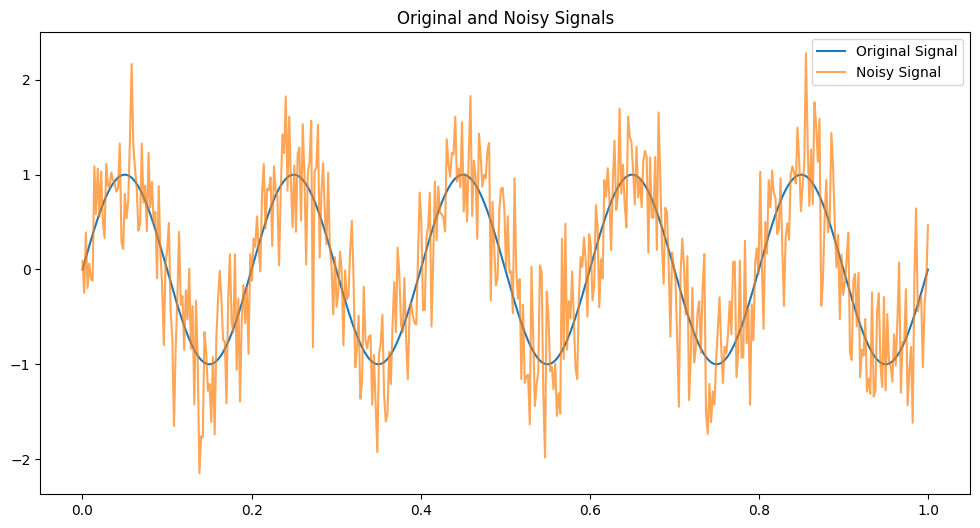

In [2]:

# Generate a sample signal
t = np.linspace(0, 1, 500)
signal = np.sin(2 * np.pi * 5 * t)  # A 5 Hz sine wave

# Add some noise
noise = np.random.normal(0, 0.5, signal.shape)
noisy_signal = signal + noise

# Plot the signals
plt.figure(figsize=(12, 6))
plt.plot(t, signal, label='Original Signal')
plt.plot(t, noisy_signal, label='Noisy Signal', alpha=0.7)
plt.legend()
plt.title('Original and Noisy Signals')
plt.show()



## Technique 1: Moving Average

The moving average is a simple but effective denoising technique, especially for time-series data. It works by averaging the data points over a sliding window, which smooths out short-term fluctuations and highlights longer-term trends.


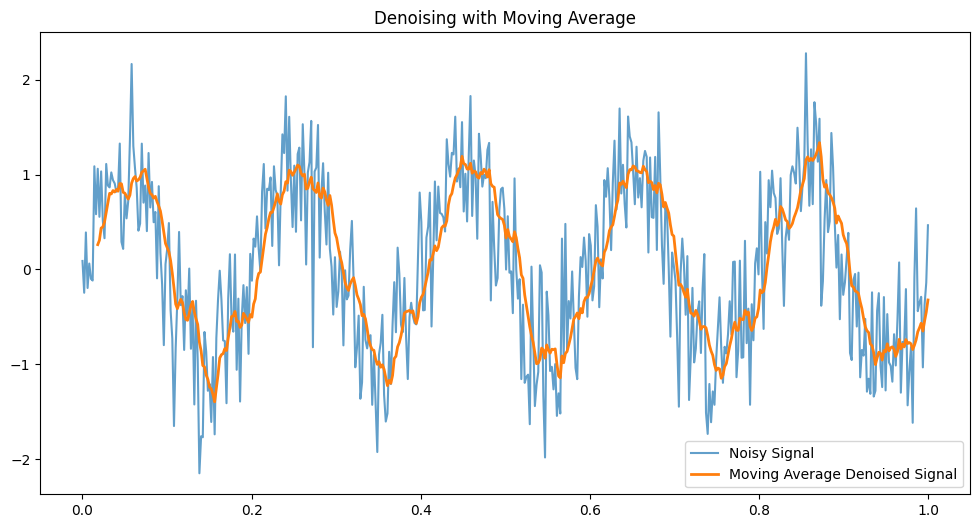

In [3]:

def moving_average(signal, window_size=10):
    return np.convolve(signal, np.ones(window_size)/window_size, mode='valid')

# Denoise the signal using moving average
ma_denoised_signal = moving_average(noisy_signal)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(t, noisy_signal, label='Noisy Signal', alpha=0.7)
plt.plot(t[len(t) - len(ma_denoised_signal):], ma_denoised_signal, label='Moving Average Denoised Signal', linewidth=2)
plt.legend()
plt.title('Denoising with Moving Average')
plt.show()



## Technique 2: Principal Component Analysis (PCA) Denoising

PCA is a dimensionality reduction technique that can be used for denoising. The idea is to project the data onto a lower-dimensional subspace that captures the most important features of the data, and then project it back to the original space. This process can remove the noise, which is assumed to be in the lower-variance components.


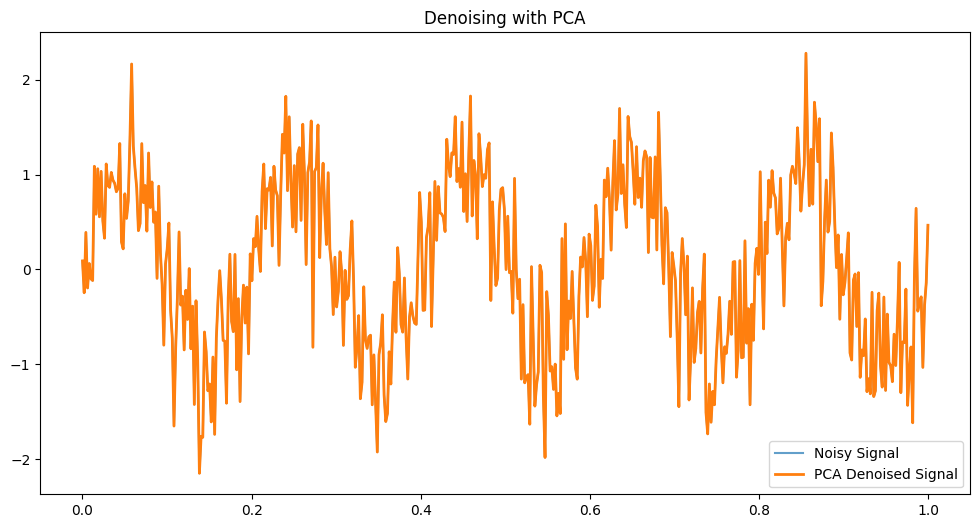

In [4]:

# Reshape data for PCA
X = noisy_signal.reshape(-1, 1)

# Apply PCA
pca = PCA(n_components=1)
pca.fit(X)
X_denoised = pca.inverse_transform(pca.transform(X))

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(t, noisy_signal, label='Noisy Signal', alpha=0.7)
plt.plot(t, X_denoised, label='PCA Denoised Signal', linewidth=2)
plt.legend()
plt.title('Denoising with PCA')
plt.show()



## Technique 3: Wavelet Denoising

Wavelet denoising is a popular technique for denoising signals and images. It involves transforming the signal into the wavelet domain, thresholding the wavelet coefficients to remove noise, and then transforming the signal back to its original domain.


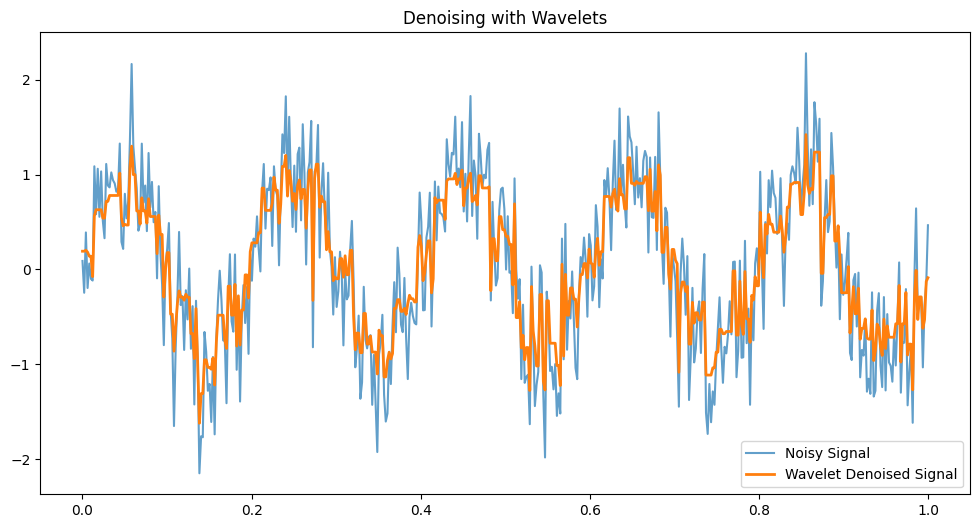

In [5]:

# Wavelet transform
coeffs = pywt.wavedec(noisy_signal, 'db1', level=6)

# Thresholding
threshold = 0.4
coeffs_thresholded = [pywt.threshold(c, threshold, mode='soft') for c in coeffs]

# Inverse wavelet transform
wavelet_denoised_signal = pywt.waverec(coeffs_thresholded, 'db1')

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(t, noisy_signal, label='Noisy Signal', alpha=0.7)
plt.plot(t, wavelet_denoised_signal[:len(t)], label='Wavelet Denoised Signal', linewidth=2)
plt.legend()
plt.title('Denoising with Wavelets')
plt.show()



## Technique 4: Autoencoder Denoising

A denoising autoencoder is a type of neural network that is trained to reconstruct a clean version of a noisy input. The autoencoder consists of an encoder that maps the input to a lower-dimensional representation, and a decoder that reconstructs the input from this representation.


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


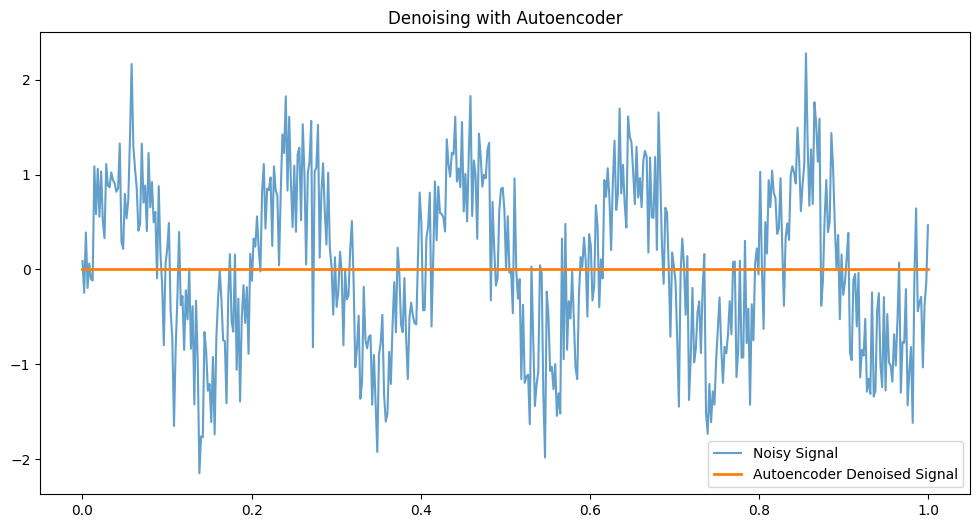

In [6]:

# Prepare the data
scaler = MinMaxScaler()
X_train_noisy = scaler.fit_transform(noisy_signal.reshape(-1, 1))
X_train_clean = scaler.transform(signal.reshape(-1, 1))

# Build the autoencoder
input_signal = Input(shape=(1,))
encoded = Dense(10, activation='relu')(input_signal)
encoded = Dense(1, activation='relu')(encoded)
decoded = Dense(10, activation='relu')(encoded)
decoded = Dense(1, activation='sigmoid')(decoded)

autoencoder = Model(input_signal, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
autoencoder.fit(X_train_noisy, X_train_clean, epochs=100, batch_size=32, shuffle=True, validation_data=(X_train_noisy, X_train_clean), verbose=0)

# Denoise the signal
X_denoised_autoencoder = autoencoder.predict(X_train_noisy)
autoencoder_denoised_signal = scaler.inverse_transform(X_denoised_autoencoder)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(t, noisy_signal, label='Noisy Signal', alpha=0.7)
plt.plot(t, autoencoder_denoised_signal, label='Autoencoder Denoised Signal', linewidth=2)
plt.legend()
plt.title('Denoising with Autoencoder')
plt.show()



## Evaluating Denoising Performance

We can evaluate the performance of the denoising techniques using metrics such as Mean Squared Error (MSE) and Signal-to-Noise Ratio (SNR).


In [7]:

from sklearn.metrics import mean_squared_error

def snr(original, denoised):
    noise = original - denoised
    return 10 * np.log10(np.sum(original**2) / np.sum(noise**2))

# Calculate MSE
mse_ma = mean_squared_error(signal[len(signal) - len(ma_denoised_signal):], ma_denoised_signal)
mse_pca = mean_squared_error(signal, X_denoised)
mse_wavelet = mean_squared_error(signal, wavelet_denoised_signal[:len(signal)])
mse_autoencoder = mean_squared_error(signal, autoencoder_denoised_signal)

# Calculate SNR
snr_ma = snr(signal[len(signal) - len(ma_denoised_signal):], ma_denoised_signal)
snr_pca = snr(signal, X_denoised.flatten())
snr_wavelet = snr(signal, wavelet_denoised_signal[:len(signal)])
snr_autoencoder = snr(signal, autoencoder_denoised_signal.flatten())

print(f'Moving Average - MSE: {mse_ma:.4f}, SNR: {snr_ma:.4f}')
print(f'PCA - MSE: {mse_pca:.4f}, SNR: {snr_pca:.4f}')
print(f'Wavelet - MSE: {mse_wavelet:.4f}, SNR: {snr_wavelet:.4f}')
print(f'Autoencoder - MSE: {mse_autoencoder:.4f}, SNR: {snr_autoencoder:.4f}')


Moving Average - MSE: 0.0639, SNR: 8.9899
PCA - MSE: 0.2369, SNR: 3.2345
Wavelet - MSE: 0.0821, SNR: 7.8399
Autoencoder - MSE: 0.4990, SNR: -0.0000



## Summary and Conclusion

This notebook has demonstrated four different techniques for denoising data. Here is a summary of the pros and cons of each method:

| Technique          | Pros                               | Cons                                    |
| ------------------ | ---------------------------------- | --------------------------------------- |
| Moving Average     | Simple to implement and understand | Can cause signal distortion (smoothing) |
| PCA                | Effective for high-dimensional data | Assumes linear relationships in the data |
| Wavelet Denoising  | Good for non-stationary signals    | Can be sensitive to parameter choices   |
| Autoencoder        | Can learn complex patterns         | Requires more data and computation      |

Choosing the right denoising technique depends on the specific characteristics of your data and the problem you are trying to solve.
